# Set Up

In [1]:
import os
import numpy as np
import nibabel as nib
from dipy.io.image import load_nifti
from dipy.io import read_bvals_bvecs
import matplotlib.pyplot as plt
import sigpy as sp
import sigpy.plot as pl
import numpy as np
import nibabel as nib
import dipy.reconst.dti as dti
from dipy.io.image import load_nifti, save_nifti
from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
import os
import nibabel as nib
from dipy.data import fetch_bundles_2_subjects
from dipy.io.image import load_nifti, load_nifti_data
import scipy

In [2]:
# Get list of .nii.gz files in the directory 
path = "Data/"
extensions = '.nii.gz'
filelist = []
bvallist = []
bveclist = []
diffdirlist = []
ii=1

for subdir, dirs, files in os.walk(path):
        for file in files:
            ext = os.path.splitext(file)[-1].lower()
            if ext in extensions:
                t=str(os.path.splitext(file))
                if t[-12:-9] == 'nii':
                    example_filename = os.path.join(subdir, file)
                    name = example_filename.split('/')
                    name1 = name[1].split('_')

                    if name1[0] == "processedDWI":
                        filelist.append(example_filename)
                        
            if ext == '.bval':
                t=str(os.path.splitext(file))
                example_filename = os.path.join(subdir, file)
                name = example_filename.split('/')
                name1 = name[1].split('_')

                if name1[0] == "processedDWI":
                    bvallist.append(example_filename)
                    
            if ext == '.bvec':
                t=str(os.path.splitext(file))
                example_filename = os.path.join(subdir, file)
                name = example_filename.split('/')
                name1 = name[1].split('_')

                if name1[0] == "processedDWI":
                    bveclist.append(example_filename)
                    
            if ext == '.mat':
                t=str(os.path.splitext(file))
                example_filename = os.path.join(subdir, file)
                name = example_filename.split('/')
                name1 = name[1].split('_')
                
                
                diffdirlist.append(example_filename)

# List of MR Data, bvalues, and bvecs                    
scanlist = list(np.sort(filelist))
bvals = list(np.sort(bvallist))
bvecs = list(np.sort(bveclist))
diffdirs = list(np.sort(diffdirlist))

In [3]:
## Load 1 image file 
from skimage.transform import rescale, resize, downscale_local_mean
import scipy.io
from dipy.io import read_bvals_bvecs

num = 0
data, affine1, img = load_nifti(scanlist[num], return_img=True)
bval, bvec = read_bvals_bvecs(bvals[num], bvecs[num])

optimaldirs = scipy.io.loadmat(diffdirs[num])
sixDirs = optimaldirs['ind_all'] - 1

In [4]:
# Generate Training, Validation, and Testing Data
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import fractional_anisotropy, color_fa
from dipy.segment.mask import median_otsu
import random

cropx=int(128)
cropy=int(128)
factor = data.shape[0]/cropx
cropz = int(data.shape[2] // factor)

model_in = np.zeros((cropx,cropy,cropz,7,sixDirs.shape[0]))
model_out = np.zeros((cropx,cropy,cropz,1,sixDirs.shape[0]))

# Sort Diffusion 
b0s = data[:,:,:,bval<10]
meanb0 = np.mean(b0s,3)
dwis = data[:,:,:,bval>10]
bvals_dwi = bval[bval > 10]
bvecs_dwi = bvec[bval>100,:]
dirs = bvec[bval>100,:]

for ii in range(0,sixDirs.shape[0]): #sixDirs.shape[0]
    b0 = b0s[:,:,:,random.randint(0,b0s.shape[-1]-1)]
    data1 = np.concatenate((b0[:,:,:,np.newaxis],dwis[:,:,:,list(sixDirs[ii,:])]),axis = -1)
    shape = np.shape(data1)
    
    # Input Array Make [6 diffusion directions]
    padded_array = np.pad(data1,((0,0),(2,2),(0,0),(0,0)))
    
    F = sp.linop.FFT(padded_array.shape, axes=(0, 1, 2))
    kspc = F(padded_array)
    
    
    x,y,z,dd = kspc.shape   # Get dimensions
    startx = int(x//2-(cropx//2))
    starty = int(y//2-(cropy//2))  
    startz = int(z//2-(cropz//2))  
    
    kspc_crop = kspc[startx:startx+cropx,starty:starty+cropy,startz:startz+cropz,:]
    Fcrop = sp.linop.FFT(kspc_crop.shape, axes=(0,1,2))
    im_crop =abs(Fcrop.H(kspc_crop))

    _, mask = median_otsu(im_crop[:,:,:,0])
    maskdata = im_crop * np.repeat(mask[:,:,:,np.newaxis],im_crop.shape[-1],axis=-1)
    model_in[:,:,:,:,ii] = maskdata
    
    #Output Array Make [calculated FA from 20 Diffusion Directions]
    dirs20 = random.sample(range(bvals_dwi.shape[0]),20)
    bvals_20dirs = np.insert(bvals_dwi[dirs20],0,0,axis = 0)
    bvecs_20dirs = np.insert(bvecs_dwi[dirs20,:],0,[0,0,0],axis = 0)
    gtab = gradient_table(bvals_20dirs, bvecs_20dirs)
    
    data1 = np.concatenate((b0[:,:,:,np.newaxis],dwis[:,:,:,dirs20]),axis = -1)
    shape = np.shape(data1)
    
    padded_array = np.pad(data1,((0,0),(2,2),(0,0),(0,0)))
    
    F = sp.linop.FFT(padded_array.shape, axes=(0, 1, 2))
    kspc = F(padded_array)
    
    
    x,y,z,dd = kspc.shape   # Get dimensions
    startx = int(x//2-(cropx//2))
    starty = int(y//2-(cropy//2))  
    startz = int(z//2-(cropz//2))  
    
    kspc_crop = kspc[startx:startx+cropx,starty:starty+cropy,startz:startz+cropz,:]
    Fcrop = sp.linop.FFT(kspc_crop.shape, axes=(0,1,2))
    im_crop =abs(Fcrop.H(kspc_crop))

    _, mask = median_otsu(im_crop[:,:,:,0])   

    maskdata = im_crop * np.repeat(mask[:,:,:,np.newaxis],im_crop.shape[-1],axis=-1)

    tenmodel = dti.TensorModel(gtab)
    tenfit = tenmodel.fit(maskdata)
    
    FA = fractional_anisotropy(tenfit.evals)
    FA[np.isnan(FA)] = 0
    fa_img = nib.Nifti1Image(FA.astype(np.float32), np.eye(4))
    
    
    model_out[:,:,:,0,ii] = FA
    
    print(ii,end=' ')

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 

In [5]:
# Save training, test, and validaiton data
from numpy import save
save('Training/model_in.npy',(model_in))
save('Training/model_out.npy',model_out)

In [6]:
idx = np.arange(0,model_in.shape[-1]-7,4)
idx_train = np.delete(np.arange(80),idx)
train_in = (model_in[:,:,:,:,idx_train])
train_in1 = np.transpose(train_in,(3,0,1,2,4))
train_in1 = np.reshape(train_in1,(train_in.shape[3],train_in.shape[0],train_in.shape[1],train_in.shape[2]*train_in.shape[4]))
train_in1 = np.transpose(train_in1,(0,-1,1,2))

train_out = (model_out[:,:,:,:,idx_train])
train_out1 = np.transpose(train_out,(3,0,1,2,4))
train_out1 = np.reshape(train_out1,(train_out.shape[3],train_out.shape[0],train_out.shape[1],train_out.shape[2]*train_out.shape[4]))
train_out1 = np.transpose(train_out1,(0,-1,1,2))


save('Training/train/data_in.npy',train_in1)
save('Training/train/data_out.npy',train_out1)
val_idx = idx[::2]
val_in = model_in[:,:,:,:,val_idx]
val_in1 = np.transpose(val_in,(3,0,1,2,4))
val_in1 = np.reshape(val_in1,(val_in.shape[3],val_in.shape[0],val_in.shape[1],val_in.shape[2]*val_in.shape[4]))
val_in1 = np.transpose(val_in1,(0,-1,1,2))


val_out = model_out[:,:,:,:,val_idx]
val_out1 = np.transpose(val_out,(3,0,1,2,4))
val_out1 = np.reshape(val_out1,(val_out.shape[3],val_out.shape[0],val_out.shape[1],val_out.shape[2]*val_out.shape[4]))
val_out1 = np.transpose(val_out1,(0,-1,1,2))

save('Training/val/data_in.npy',val_in1)
save('Training/val/data_out.npy',val_out1)


test_in = model_in[:,:,:,:,idx[1::2]]
test_in1 = np.transpose(test_in,(3,0,1,2,4))
test_in1 = np.reshape(test_in1,(test_in.shape[3],test_in.shape[0],test_in.shape[1],test_in.shape[2]*test_in.shape[4]))
test_in1 = np.transpose(test_in1,(0,-1,1,2))

test_out = model_out[:,:,:,:,idx[1::2]]
test_out1 = np.transpose(test_out,(3,0,1,2,4))
test_out1 = np.reshape(test_out1,(test_out.shape[3],test_out.shape[0],test_out.shape[1],test_out.shape[2]*test_out.shape[4]))
test_out1 = np.transpose(test_out1,(0,-1,1,2))

save('Training/test/data_in.npy',test_in1)
save('Training/test/data_out.npy',test_out1)

print(train_in1.shape,train_out1.shape)
print(val_in1.shape,val_out1.shape)
print(test_in1.shape,test_out1.shape)

(7, 5040, 128, 128) (1, 5040, 128, 128)
(7, 840, 128, 128) (1, 840, 128, 128)
(7, 840, 128, 128) (1, 840, 128, 128)


# Ground Truth for Each Dataset

In [ ]:
## Load 1 image file 
from skimage.transform import rescale, resize, downscale_local_mean
import scipy.io
from dipy.io import read_bvals_bvecs

num = 0
data, affine1, img = load_nifti(scanlist[num], return_img=True)
bval, bvec = read_bvals_bvecs(bvals[num], bvecs[num])

optimaldirs = scipy.io.loadmat(diffdirs[num])
sixDirs = optimaldirs['ind_all'] - 1

In [ ]:
# Generate Training, Validation, and Testing Data
from dipy.core.gradients import gradient_table
from dipy.reconst.dti import fractional_anisotropy, color_fa
from dipy.segment.mask import median_otsu
import random
from numpy import save


for num in range(len(scanlist)):
    data, affine1, img = load_nifti(scanlist[num], return_img=True)
    bval, bvec = read_bvals_bvecs(bvals[num], bvecs[num])

    optimaldirs = scipy.io.loadmat(diffdirs[num])
    sixDirs = optimaldirs['ind_all'] - 1

    cropx=int(128)
    cropy=int(128)
    factor = data.shape[0]/cropx
    cropz = int(data.shape[2] // factor)


    # Sort Diffusion 
    b0s = data[:,:,:,bval<10]
    meanb0 = np.mean(b0s,3)
    dwis = data[:,:,:,bval>10]
    bvals_dwi = bval[bval > 10]
    bvecs_dwi = bvec[bval>100,:]
    dirs = bvec[bval>100,:]

    # Generate Ground Truth for Comparison
    data1 = np.concatenate((meanb0[:,:,:,np.newaxis],dwis[:,:,:,:]),axis = -1)
    shape = np.shape(data1)

    # Input Array Make
    padded_array = np.pad(data1,((0,0),(2,2),(0,0),(0,0)))

    F = sp.linop.FFT(padded_array.shape, axes=(0, 1, 2))
    kspc = F(padded_array)

    x,y,z,dd = kspc.shape   # Get dimensions
    startx = int(x//2-(cropx//2))
    starty = int(y//2-(cropy//2))  
    startz = int(z//2-(cropz//2))  

    kspc_crop = kspc[startx:startx+cropx,starty:starty+cropy,startz:startz+cropz,:]
    Fcrop = sp.linop.FFT(kspc_crop.shape, axes=(0,1,2))
    im_crop =abs(Fcrop.H(kspc_crop))

    #Output Array Make
    bvals_6dirs = np.insert(bvals_dwi,0,0,axis = 0)
    bvecs_6dirs = np.insert(bvecs_dwi,0,[0,0,0],axis = 0)
    gtab = gradient_table(bvals_6dirs, bvecs_6dirs)

    _, mask = median_otsu(im_crop[:,:,:,0])

    maskdata = im_crop * np.repeat(mask[:,:,:,np.newaxis],im_crop.shape[-1],axis=-1)
    tenmodel = dti.TensorModel(gtab)
    tenfit = tenmodel.fit(maskdata)

    FA = fractional_anisotropy(tenfit.evals)
    FA[np.isnan(FA)] = 0
    fa_img = nib.Nifti1Image(FA.astype(np.float32), np.eye(4))


    savename_in = 'Data_adjusted/gt_' + scanlist[num].split('/')[1] + 'in'
    savename_out = 'Data_adjusted/gt_' + scanlist[num].split('/')[1] + 'out'
    save(savename_in,(im_crop))
    save(savename_out,(FA))
    
    print(num,end = ' ')

# Testing Things

In [86]:
from nilearn.masking import compute_epi_mask
from dipy.segment.mask import median_otsu
maskdata = im_crop * np.repeat(mask[:,:,:,np.newaxis],im_crop.shape[-1],axis=-1)
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata)
FA = fractional_anisotropy(tenfit.evals)
FA[np.isnan(FA)] = 0

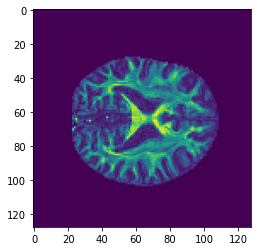

In [9]:
FA = fractional_anisotropy(tenfit.evals)
FA[np.isnan(FA)] = 0
#fa_img = nib.Nifti1Image(FA.astype(np.float32), np.eye(4))
plt.imshow(FA[:,:,43])
plt.show()
MD2 = tenfit.md


In [8]:
## Get FA from image_resized 

gtab = gradient_table(bvals, bvecs)
maskdata, mask = median_otsu(meanb0[:,:,0], median_radius=3, numpass=20)
tenmodel = dti.TensorModel(gtab)
tenfit = tenmodel.fit(maskdata)
print('Computing anisotropy measures (FA, MD, RGB)')


FA = fractional_anisotropy(tenfit.evals)
FA[np.isnan(FA)] = 0

(146, 144, 5, 156)

In [101]:
sixDirs.shape

(87, 6)

In [78]:
cropx=int(128)
cropy=int(128)
factor = data.shape[0]/cropx
cropz = int(data.shape[2] // factor)
print(cropz)

84
